In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Preprocessing

In [2]:
df = pd.read_csv('../../../raw_data/2011_2021_caluire_phys_v0.csv')

In [3]:
df = df[['DatePrel', '1340']]
df

,DatePrel,1340
0,2011-11-22,11.1
1,2012-01-23,13.0
2,2012-02-14,13.0
3,2012-03-12,10.6
4,2012-04-24,10.6
...,...,...
179,2021-06-07,9.3
180,2021-06-25,8.5
181,2021-07-09,8.9
182,2021-07-29,6.9


In [4]:
df['DatePrel'] = pd.to_datetime(df['DatePrel'])
df['month'] = df['DatePrel'].dt.month
df['year'] = df['DatePrel'].dt.year

In [5]:
df = df.groupby(['year', 'month'], as_index = False).mean()

In [6]:
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = 1), format = '%Y%m')

In [7]:
#df = df.drop(columns = ['DatePrel', 'month', 'year'])
df = df.set_index('date')

In [8]:
df = df.rename(columns = {'1340' : 'nitrates'})

In [9]:
df = df.groupby(['date']).mean()

In [10]:
#df.index = pd.DatetimeIndex(df.index).to_period('M')

In [11]:
df.head(12)

,year,month,nitrates
date,,,
2011-11-01,2011.0,11.0,11.10
2012-01-01,2012.0,1.0,13.00
2012-02-01,2012.0,2.0,13.00
2012-03-01,2012.0,3.0,10.60
2012-04-01,2012.0,4.0,10.60
2012-05-01,2012.0,5.0,9.70
2012-06-01,2012.0,6.0,10.10
2012-07-01,2012.0,7.0,8.75
2012-08-01,2012.0,8.0,6.80


# Modeling

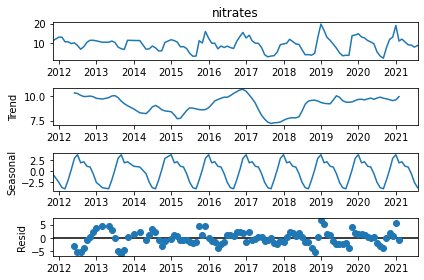

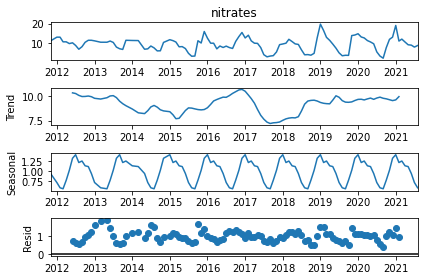

In [12]:
result_add = seasonal_decompose(df['nitrates'], model='additive', period=12)
result_add.plot();

result_mul = seasonal_decompose(df['nitrates'], model = 'multiplicative', period = 12)
result_mul.plot();

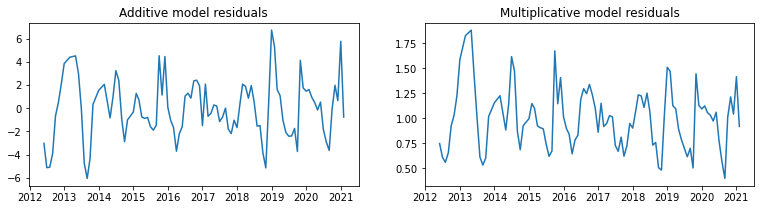

In [13]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

In [14]:
# ADF Test p-values
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multipl resid:  ', adfuller(result_mul.resid.dropna())[1])

additive resid:  1.0115092956011841e-05
multipl resid:   1.4682861685960089e-07


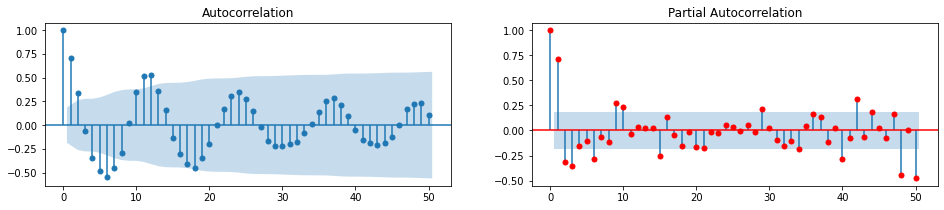

In [15]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.nitrates, lags=50, ax=axes[0]);
plot_pacf(df.nitrates, lags=50, ax=axes[1], color='r');

In [16]:
p = 3
q = 2

In [17]:
def differentials(df):
    zero_diff = df.nitrates
    first_order_diff = df.nitrates.diff(1)
    second_order_diff = df.nitrates.diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df.nitrates.values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

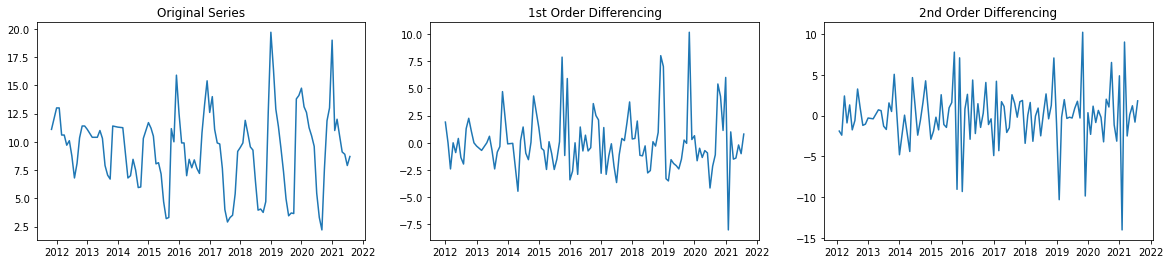

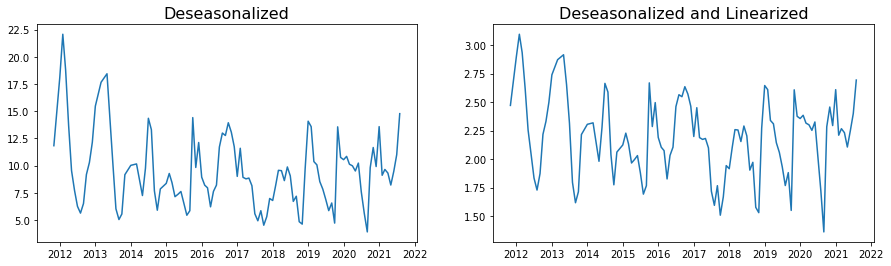

In [18]:
plot_differentials(df)
plot_deseasonalized(df)

In [19]:
print('p-value zero-diff:   ', adfuller(differentials(df)[0])[1])
print('p-value first-diff:  ', adfuller(differentials(df)[1].dropna())[1])
print('p-value second-diff: ', adfuller(differentials(df)[2].dropna())[1])

p-value zero-diff:    0.08542729310678043
p-value first-diff:   1.4638412861306518e-14
p-value second-diff:  5.645326601839832e-13


In [20]:
d = 1

In [21]:
111 * 0.8

88.80000000000001

In [22]:
train = deseasonalized(df)[1][:89]
test = deseasonalized(df)[1][89:]

In [23]:
print(train.shape, test.shape)

(89,) (22,)


In [24]:
print(p, d, q)

3 1 2


## ARIMA

In [25]:
arima = ARIMA(train, order=(p,d,q)).fit()

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16178D-02    |proj g|=  5.93341D+00

At iterate    5    f= -7.62068D-02    |proj g|=  1.27584D+00

At iterate   10    f= -7.95624D-02    |proj g|=  2.21757D-01

At iterate   15    f= -7.97372D-02    |proj g|=  2.70220D-01

At iterate   20    f= -8.10403D-02    |proj g|=  6.07132D-02

At iterate   25    f= -8.47898D-02    |proj g|=  1.38240D-01

At iterate   30    f= -8.86955D-02    |proj g|=  2.33325D-02

At iterate   35    f= -8.87997D-02    |proj g|=  1.93584D-03

At iterate   40    f= -8.87997D-02    |proj g|=  8.20316D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [26]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.linearized   No. Observations:                   88
Model:                 ARIMA(3, 1, 2)   Log Likelihood                   7.814
Method:                       css-mle   S.D. of innovations              0.215
Date:                Wed, 24 Nov 2021   AIC                             -1.629
Time:                        16:26:30   BIC                             15.713
Sample:                             1   HQIC                             5.358
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0039      0.001     -2.921      0.003      -0.007      -0.001
ar.L1.D.linearized     1.6146      0.420      3.848      0.000       0.792       2.437
ar.L2.D.linearized    -0.8667      0.490     -1.769      0.077      -1.827       0.093
ar.L3.D.linearized     0.0719      0.253      0.284      0.777      -0.425       0.568
ma.L1.D.linearized    -1.7558      0.409     -4.290      0.000      -2.558      -0.954
ma.L2.D.linearized     0.7558      0.409      1.850      0.064      -0.045       1.557
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0597           -0.5262j            1.1832           -0.0734
AR.2            1.0597           +0.5262j            1.1832            0.0734
AR.3            9.9360           -0.0000j            9.9360           -0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.3232           +0.0000j            1.3232            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
forecast_arima_1, std_err_arima_1, confidence_int_arima_1 = arima.forecast(len(test), alpha=0.05)

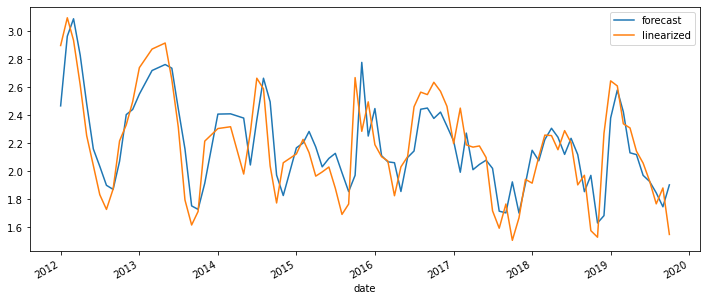

In [28]:
arima.plot_predict()#end=111);
fig = plt.gcf(); fig.set_size_inches(12, 5);

In [29]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

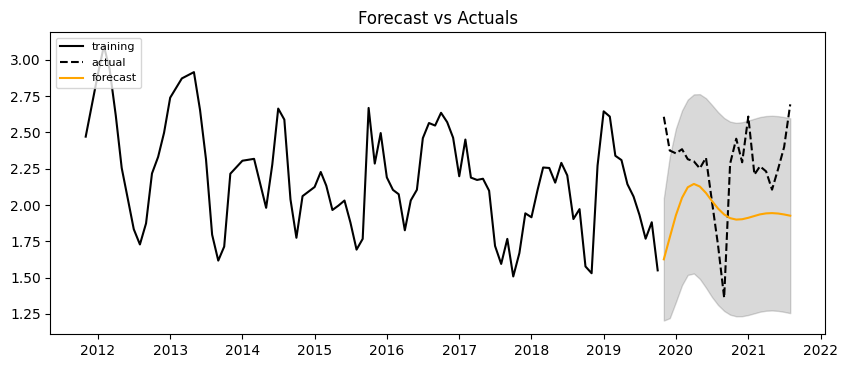

In [30]:
plot_forecast(forecast_arima_1, train, test, confidence_int_arima_1[:,0], confidence_int_arima_1[:,1])

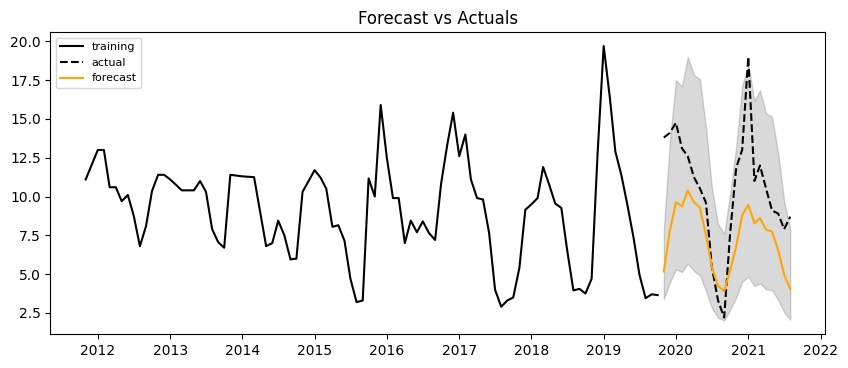

In [136]:
forecast_recons = np.exp(forecast_arima_1)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int_arima_1)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int_arima_1)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

In [137]:
smodel = pm.auto_arima(train,
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17.431, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=395.286, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=286.476, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19.426, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19.411, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=207.537, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17.703, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20.881, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=0.694, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20.623, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5.410, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3.981, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-0.351, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1.282, Time=0.07 sec
 

In [141]:
# (2,0,2)
#ValueError: The computed initial MA coefficients are not invertible
#You should induce invertibility, choose a different model order, or you can
#pass your own start_params.

In [142]:
arima_2 = ARIMA(train, order=(2,1,2)).fit()
arima_2.summary()
forecast_arima_2, std_err_arima_2, confidence_int_arima_2 = arima_2.forecast(len(test), alpha=0.05)

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35044D-02    |proj g|=  2.63144D-01

At iterate    5    f= -4.91719D-02    |proj g|=  1.21045D-02

At iterate   10    f= -7.59206D-02    |proj g|=  2.68493D-01

At iterate   15    f= -8.41477D-02    |proj g|=  1.00970D-02

At iterate   20    f= -8.44831D-02    |proj g|=  6.14803D-01

At iterate   25    f= -8.80252D-02    |proj g|=  1.09450D-02

At iterate   30    f= -8.80257D-02    |proj g|=  2.47937D-03

At iterate   35    f= -8.80281D-02    |proj g|=  2.30519D-02

At iterate   40    f= -8.80295D-02    |proj g|=  6.52801D-03

At iterate   45    f= -8.80297D-02    |proj g|=  7.64060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


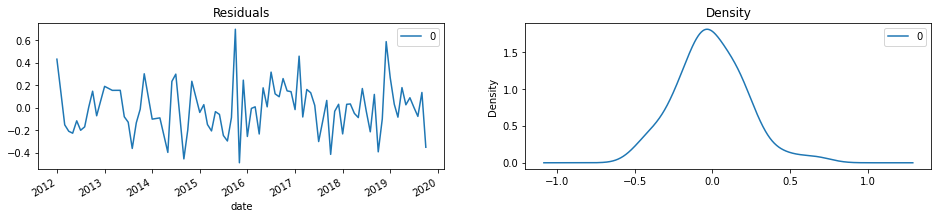

In [35]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

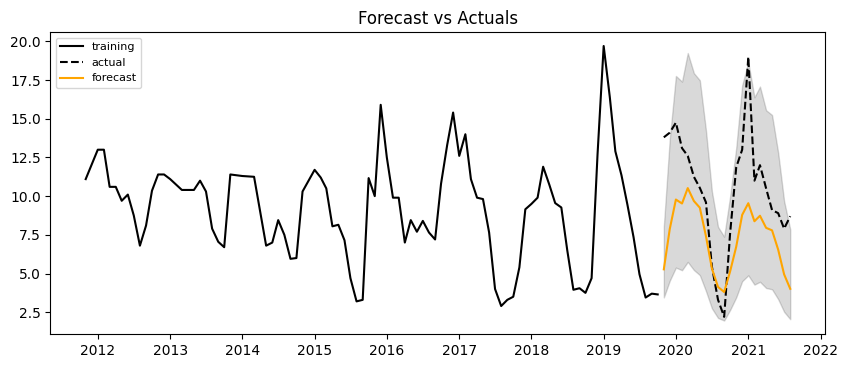

In [143]:
forecast_recons = np.exp(forecast_arima_2)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int_arima_2)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int_arima_2)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

## SARIMA

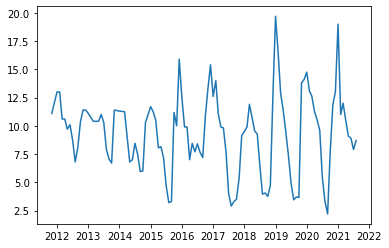

In [36]:
plt.plot(df['nitrates'])

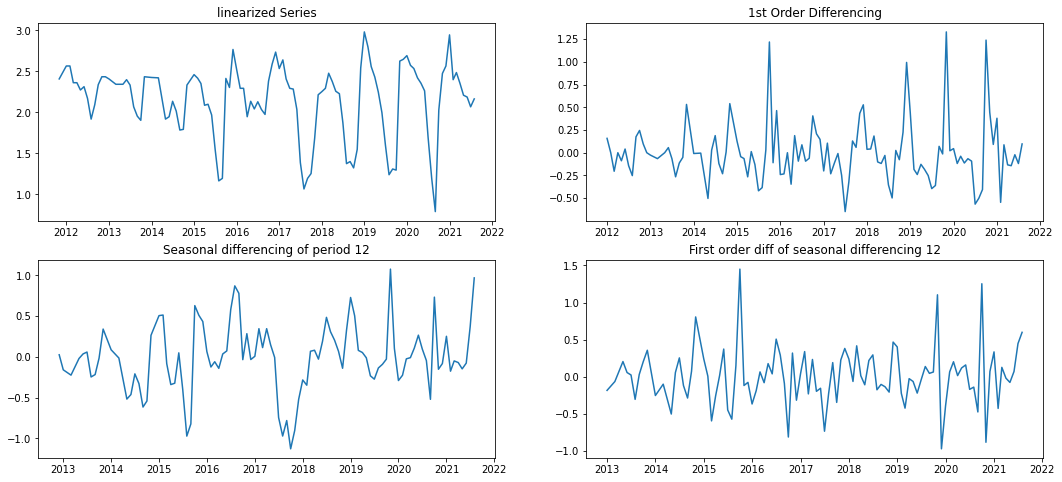

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.nitrates)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [ ]:
P = 
D = 
Q = 
S = 12

In [38]:
train = df.log[0:89]
test = df.log[89:]

In [144]:
smodel_2 = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=3, max_d=2, start_q=0, max_q=3,
                       start_P=0, max_P=3, max_D=2, start_Q=0, max_Q=3, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=73.608, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5.361, Time=0.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=18.406, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=395.286, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5.410, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7.321, Time=1.34 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5.545, Time=0.18 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7.748, Time=1.28 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=69.283, Time=0.28 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-2.647, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-2.551, Time=0.08 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-0.674, Time=1.32 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-2.490, Time=0

In [149]:
# Build Model
sarima = SARIMAX(train, order=(2, 0, 0),seasonal_order=(1,0,0,12))
sarima = sarima.fit()
forecast_sarima, std_err_sarima, confidence_int_sarima = sarima.forecast(len(test), alpha=0.05)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77215D-01    |proj g|=  4.17997D-01

At iterate    5    f=  6.18441D-02    |proj g|=  5.07026D-02

At iterate   10    f=  5.82715D-02    |proj g|=  7.30719D-03

At iterate   15    f=  5.67635D-02    |proj g|=  8.57721D-03

At iterate   20    f=  5.67567D-02    |proj g|=  2.82250D-04

At iterate   25    f=  5.67501D-02    |proj g|=  2.66885D-03

At iterate   30    f=  5.66416D-02    |proj g|=  9.53872D-03

At iterate   35    f=  5.65280D-02    |proj g|=  1.25721D-02

At iterate   40    f=  5.64101D-02    |proj g|=  2.19396D-03

At iterate   45    f=  5.63666D-02    |proj g|=  3.41772D-03

At iterate   50    f=  5.61650D-02    |proj g|=  6.90882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


AttributeError: 'RangeIndex' object has no attribute 'end'

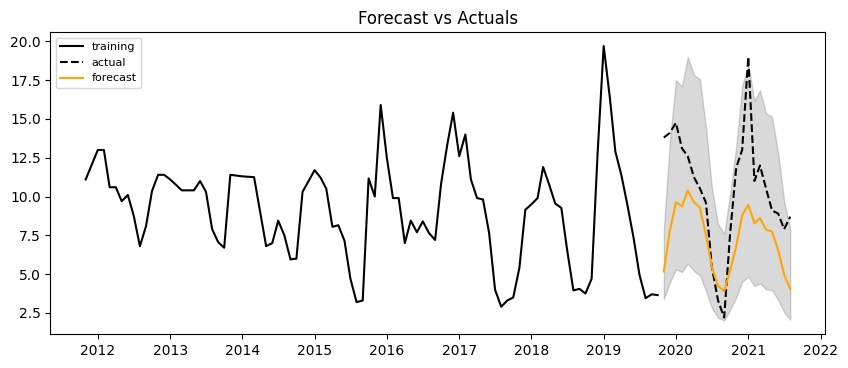

In [150]:
forecast_recons = np.exp(forecast)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)